In [234]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import numbers

from PIL import Image
import math


In [235]:
class RandomRotation:
    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        angle = np.random.uniform(degrees[0], degrees[1])
        return angle

    def __call__(self, img):        
        def rotate(img, angle, resample=False, expand=False, center=None):
            return img.rotate(angle, resample, expand, center)

        angle = self.get_params(self.degrees)
        return rotate(img, angle, self.resample, self.expand, self.center)

In [236]:
class RandomShift(object):
    def __init__(self, shift):
        self.shift = shift
        
    @staticmethod
    def get_params(shift):
        hshift, vshift = np.random.uniform(-shift, shift, size=2)
        return hshift, vshift 
    
    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)
        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)

In [237]:
training_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transforms.Compose([
    RandomRotation(degrees=20), 
    RandomShift(3),
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.5,), std=(0.5,))
]))

validation_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.5,), std=(0.5,))
]))

In [238]:
training_dataset, validation_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ), Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ))

In [239]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=True)

In [12]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()    
        self.features1 = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),        
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),  
            nn.Conv2d(20, 50, 5, 1),
            nn.BatchNorm2d(50)           
        )
        self.features2 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)  
        )
        self.classifier = nn.Sequential(
            nn.Linear(4*4*50, 500),        
            nn.ReLU(),
            nn.Linear(500, 10)         
        )
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    

In [13]:
model = Model()
model

Model(
  (features1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (features2): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=800, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [15]:
%%time
epochs = 25
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
 
for e in range(epochs):
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
  
    for inputs, labels in training_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
 
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
        
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
      
        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/ len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch :', (e+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.6267, acc 82.7733 
validation loss: 0.0912, validation acc 97.7700 
epoch : 2
training loss: 0.1883, acc 94.6567 
validation loss: 0.0597, validation acc 98.4200 
epoch : 3
training loss: 0.1358, acc 96.0200 
validation loss: 0.0476, validation acc 98.6700 
epoch : 4
training loss: 0.1150, acc 96.6183 
validation loss: 0.0413, validation acc 98.7900 
epoch : 5
training loss: 0.0968, acc 97.0717 
validation loss: 0.0363, validation acc 98.8500 
epoch : 6
training loss: 0.0893, acc 97.3083 
validation loss: 0.0363, validation acc 98.9900 
epoch : 7
training loss: 0.0782, acc 97.6150 
validation loss: 0.0368, validation acc 98.9300 
epoch : 8
training loss: 0.0722, acc 97.7883 
validation loss: 0.0330, validation acc 98.9600 
epoch : 9
training loss: 0.0666, acc 97.9883 
validation loss: 0.0271, validation acc 99.2100 
epoch : 10
training loss: 0.0638, acc 97.9967 
validation loss: 0.0312, validation acc 99.0400 
epoch : 11
training loss: 0.0602, acc 98.1333 
va

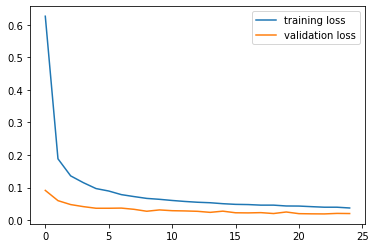

In [16]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

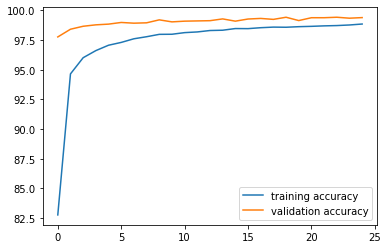

In [17]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [65]:
# Experiment parameters
lr_find_epochs = 5
start_lr = 1e-7
end_lr = 0.9

model = Model()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = start_lr)

# LR function lambda

lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len(training_loader)))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [66]:
%%time

# Run the experiment 

lr_find_loss = []
lr_find_lr = []

iter = 0

smoothing = 0.05

for i in range(lr_find_epochs):
    print("epoch {}".format(i))
    for inputs, labels in training_loader:

        # Training mode and zero gradients
        model.train()
        optimizer.zero_grad()

        # Get outputs to calc loss
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update LR
        scheduler.step()
        lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        # smooth the loss
        if iter==0:
            lr_find_loss.append(loss)
        else:
            loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
            lr_find_loss.append(loss)
     
    iter += 1

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
CPU times: user 33min 47s, sys: 51.3 s, total: 34min 38s
Wall time: 5min 36s


In [67]:
len(lr_find_loss)

3000

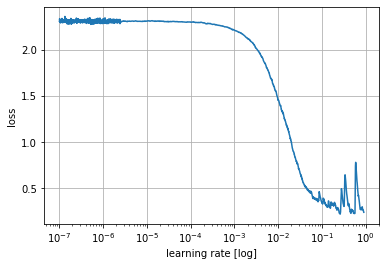

In [77]:
plt.ylabel("loss")
plt.xlabel("learning rate [log]")
plt.xscale("log")
axes = plt.gca()
# axes.set_xlim([0.03/6, 0.03])
# axes.set_ylim([ymin,ymax])
plt.plot(lr_find_lr, lr_find_loss)
plt.grid(True)
plt.show()

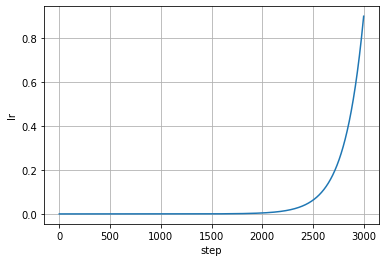

In [69]:
plt.ylabel("lr")
plt.xlabel("step")
# plt.yscale("log")
plt.plot(range(len(lr_find_lr)), lr_find_lr)
plt.grid(True)
plt.show()

In [78]:
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [79]:
model = Model()
end_lr = 0.03
factor = 6
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.)
step_size = 4*len(training_loader)
clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

In [80]:
%%time
epochs = 25
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
 
for e in range(epochs):
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
  
    for inputs, labels in training_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        scheduler.step()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
 
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
        
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
      
        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/ len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch :', (e+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

/Users/kirillvladimirov/PycharmProjects/cv_projects/venv/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch : 1
training loss: 1.4361, acc 59.6283 
validation loss: 0.3302, validation acc 94.3800 
epoch : 2
training loss: 0.4201, acc 88.6500 
validation loss: 0.1112, validation acc 97.3900 
epoch : 3
training loss: 0.2251, acc 93.6250 
validation loss: 0.0725, validation acc 98.2000 
epoch : 4
training loss: 0.1627, acc 95.2417 
validation loss: 0.0535, validation acc 98.5300 
epoch : 5
training loss: 0.1270, acc 96.3267 
validation loss: 0.0412, validation acc 98.7800 
epoch : 6
training loss: 0.1066, acc 96.8850 
validation loss: 0.0371, validation acc 99.0600 
epoch : 7
training loss: 0.0929, acc 97.2383 
validation loss: 0.0329, validation acc 99.1400 
epoch : 8
training loss: 0.0843, acc 97.4800 
validation loss: 0.0311, validation acc 99.1300 
epoch : 9
training loss: 0.0824, acc 97.5800 
validation loss: 0.0322, validation acc 99.1700 
epoch : 10
training loss: 0.0836, acc 97.4683 
validation loss: 0.0347, validation acc 99.0100 
epoch : 11
training loss: 0.0816, acc 97.5917 
va

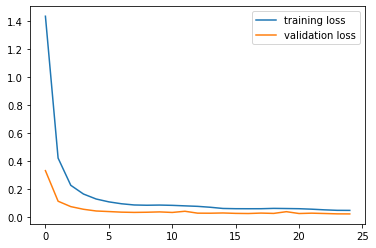

In [83]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

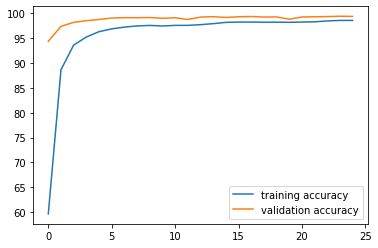

In [84]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

## Tutorial cnn

https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py#L35-L56

In [241]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


In [93]:
# Experiment parameters
lr_find_epochs = 5
start_lr = 1e-7
end_lr = 0.9

model = ConvNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = start_lr)

# LR function lambda

lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len(training_loader)))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [94]:
%%time

# Run the experiment 

lr_find_loss = []
lr_find_lr = []

iter = 0

smoothing = 0.05

for i in range(lr_find_epochs):
    print("epoch {}".format(i))
    for inputs, labels in training_loader:

        # Training mode and zero gradients
        model.train()
        optimizer.zero_grad()

        # Get outputs to calc loss
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update LR
        scheduler.step()
        lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        # smooth the loss
        if iter==0:
            lr_find_loss.append(loss)
        else:
            loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
            lr_find_loss.append(loss)
     
    iter += 1

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
CPU times: user 44min 30s, sys: 42.6 s, total: 45min 13s
Wall time: 6min 40s


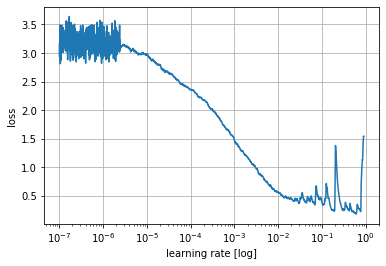

In [98]:
plt.ylabel("loss")
plt.xlabel("learning rate [log]")
plt.xscale("log")
axes = plt.gca()
# axes.set_xlim([0.03/6, 0.03])
# axes.set_ylim([ymin,ymax])
plt.plot(lr_find_lr, lr_find_loss)
plt.grid(True)
plt.show()

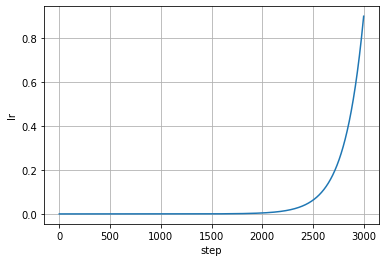

In [96]:
plt.ylabel("lr")
plt.xlabel("step")
# plt.yscale("log")
plt.plot(range(len(lr_find_lr)), lr_find_lr)
plt.grid(True)
plt.show()

In [86]:
model = ConvNet()
end_lr = 0.03
factor = 6
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.)
step_size = 4*len(training_loader)
clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

In [87]:
%%time
epochs = 25
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
 
for e in range(epochs):
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    model.train()
    
    for inputs, labels in training_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        scheduler.step()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
 
    else:
        model.eval()
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
        
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
      
        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/ len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch :', (e+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

/Users/kirillvladimirov/PycharmProjects/cv_projects/venv/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch : 1
training loss: 0.3334, acc 90.1150 
validation loss: 0.0597, validation acc 98.0700 
epoch : 2
training loss: 0.1170, acc 96.3317 
validation loss: 0.0613, validation acc 98.1300 
epoch : 3
training loss: 0.1071, acc 96.6850 
validation loss: 0.0478, validation acc 98.5300 
epoch : 4
training loss: 0.0985, acc 96.9383 
validation loss: 0.0561, validation acc 98.1100 
epoch : 5
training loss: 0.0990, acc 97.0050 
validation loss: 0.0507, validation acc 98.3600 
epoch : 6
training loss: 0.0755, acc 97.7367 
validation loss: 0.0321, validation acc 98.9800 
epoch : 7
training loss: 0.0610, acc 98.1283 
validation loss: 0.0296, validation acc 99.1000 
epoch : 8
training loss: 0.0512, acc 98.4517 
validation loss: 0.0237, validation acc 99.2600 
epoch : 9
training loss: 0.0495, acc 98.4917 
validation loss: 0.0279, validation acc 99.0900 
epoch : 10
training loss: 0.0683, acc 97.9400 
validation loss: 0.0348, validation acc 98.8900 
epoch : 11
training loss: 0.0846, acc 97.4483 
va

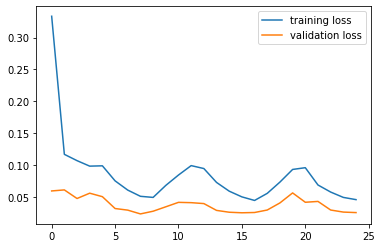

In [90]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

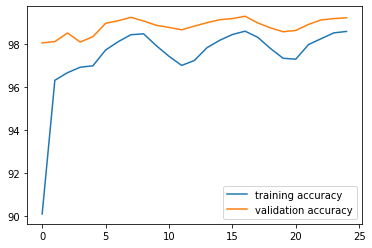

In [91]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [99]:
64 * 5 * 5

1600

In [240]:
%%time

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 28X28
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # 14X14
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # 7X7
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))
        # 5X5
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 7 * 7, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 10)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
#         out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out
    
   

CPU times: user 55 µs, sys: 17 µs, total: 72 µs
Wall time: 83.2 µs


In [122]:
model = CNN()
end_lr = 0.001
factor = 6
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.)
step_size = 4*len(training_loader)
clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

In [123]:
%%time
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
 
for e in range(epochs):
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    model.train()
    
    for inputs, labels in training_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        scheduler.step()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
 
    else:
        model.eval()
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
        
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
      
        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/ len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch :', (e+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.5153, acc 84.4033 
validation loss: 0.0616, validation acc 98.1400 
epoch : 2
training loss: 0.1564, acc 95.2317 
validation loss: 0.0421, validation acc 98.5600 
epoch : 3
training loss: 0.1172, acc 96.3467 
validation loss: 0.0313, validation acc 98.9800 
epoch : 4
training loss: 0.1037, acc 96.7850 
validation loss: 0.0395, validation acc 98.7900 
epoch : 5
training loss: 0.0881, acc 97.2917 
validation loss: 0.0305, validation acc 99.0300 
epoch : 6
training loss: 0.0681, acc 97.8567 
validation loss: 0.0320, validation acc 99.0700 
epoch : 7
training loss: 0.0582, acc 98.2583 
validation loss: 0.0214, validation acc 99.2800 
epoch : 8
training loss: 0.0495, acc 98.3967 
validation loss: 0.0221, validation acc 99.2200 
epoch : 9
training loss: 0.0498, acc 98.4250 
validation loss: 0.0181, validation acc 99.4300 
epoch : 10
training loss: 0.0535, acc 98.3133 
validation loss: 0.0224, validation acc 99.3200 
epoch : 11
training loss: 0.0612, acc 98.0733 
va

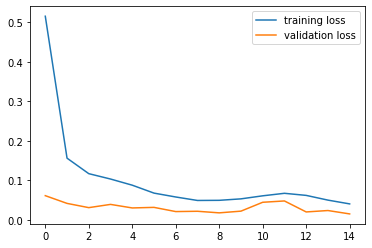

In [125]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

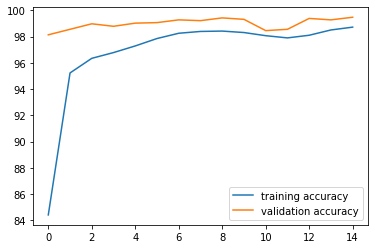

In [126]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

## Digit recognizer using Deep Neural Networks

https://www.kaggle.com/juiyangchang/cnn-with-pytorch-0-995-accuracy

In [168]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(256, 10)
        )
        
        for m in self.cnn_layers.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.fc_layers.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def forward(self, x):
        out = self.cnn_layers(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

In [254]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [255]:
model

Model(
  (features1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (features2): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=800, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [256]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
              ReLU-2           [-1, 20, 24, 24]               0
         AvgPool2d-3           [-1, 20, 12, 12]               0
            Conv2d-4             [-1, 50, 8, 8]          25,050
       BatchNorm2d-5             [-1, 50, 8, 8]             100
              ReLU-6             [-1, 50, 8, 8]               0
         AvgPool2d-7             [-1, 50, 4, 4]               0
            Linear-8                  [-1, 500]         400,500
              ReLU-9                  [-1, 500]               0
           Linear-10                   [-1, 10]           5,010
Total params: 431,180
Trainable params: 431,180
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.28
Params size (MB): 1.64
Estimated T

In [257]:
def train(model):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
#     model = model.train()
    
    for inputs, labels in training_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        scheduler.step()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/ len(training_loader)
    
    return epoch_loss, epoch_acc



# def train(model):
#     epoch_loss = 0.0
#     epoch_corrects = 0.0
    
#     model.train()
#     scheduler.step()

#     for inputs, labels in training_loader:
#         inputs, labels = Variable(inputs), Variable(labels)
        
#         optimizer.zero_grad()
#         output = model(inputs)
#         loss = criterion(output, labels)
        
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item()
# #         pred = outputs.data.max(1, keepdim=True)[1]
#         preds = torch.max(outputs, 1)[1]
#         epoch_corrects += torch.sum(preds == labels.data)
        
#     return epoch_loss/len(training_loader), epoch_corrects.float()/len(training_loader)

In [258]:
def evaluate(model):
    loss = 0.0
    corrects = 0.0
    
#     model = model.eval()
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = Variable(inputs), Variable(labels)
            outputs = model(inputs)

            loss += F.cross_entropy(outputs, labels, reduction='mean').item()
            pred = outputs.data.max(1, keepdim=True)[1]
            corrects += pred.eq(labels.data.view_as(pred)).cpu().sum()
               
    return loss/len(validation_loader), corrects.float()/len(validation_loader)

In [259]:
%%time
n_epochs = 15

epoch_loss_history = []
epoch_corrects_history = []
val_loss_history = []
val_corrects_history = []

for epoch in range(n_epochs):
    epoch_loss, epoch_corrects = train(model)
    val_loss, val_corrects = evaluate(model)
    
    epoch_loss_history.append(epoch_loss)
    epoch_corrects_history.append(epoch_corrects)
    val_running_loss_history.append(val_loss)
    val_running_corrects_history.append(val_corrects)
    
    print('epoch :', (epoch+1))
    print('training loss: {:.4f}, training acc {:.4f} '.format(epoch_loss, epoch_corrects.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_loss, val_corrects.item()))

epoch : 1
training loss: 1.6728, training acc 46.5417 
validation loss: 1.3732, validation acc 64.8400 
epoch : 2
training loss: 1.6703, training acc 46.6467 
validation loss: 1.3737, validation acc 64.7400 
epoch : 3
training loss: 1.6696, training acc 46.4567 
validation loss: 1.3737, validation acc 64.7200 
epoch : 4
training loss: 1.6675, training acc 46.7233 
validation loss: 1.3735, validation acc 64.8100 
epoch : 5
training loss: 1.6703, training acc 46.8867 
validation loss: 1.3738, validation acc 64.7100 
epoch : 6
training loss: 1.6722, training acc 46.4333 
validation loss: 1.3740, validation acc 64.6200 
epoch : 7
training loss: 1.6698, training acc 46.8683 
validation loss: 1.3741, validation acc 64.7700 
epoch : 8
training loss: 1.6711, training acc 46.5567 
validation loss: 1.3736, validation acc 64.8800 
epoch : 9
training loss: 1.6688, training acc 46.8733 
validation loss: 1.3733, validation acc 64.7400 
epoch : 10
training loss: 1.6703, training acc 46.4383 
validati

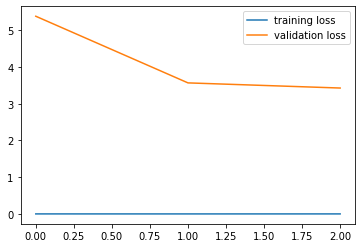

In [201]:
plt.plot(epoch_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

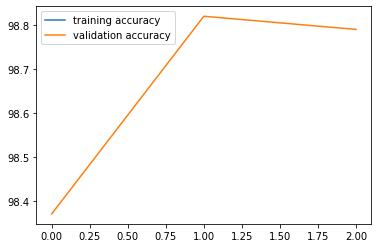

In [202]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()